# COSMOS master catalogue
## Convert COSMOS2016 to help format for comparison and homogeniety

This catalogue comes from `dmu1_COSMOS2015`. At present we will only cross match the ids into the HELP masterlist. to go into the cross id table. This will allow comparisons for our internal testing as well as allow users of the COSMOS catalogue to get other fluxes and HELP products.



In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))
import datetime
print("This notebook was executed on: \n{}".format(datetime.datetime.now()))

This notebook was run with herschelhelp_internal version: 
0246c5d (Thu Jan 25 17:01:47 2018 +0000) [with local modifications]
This notebook was executed on: 
2018-02-14 13:04:27.254677


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux, flux_to_mag

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "cosmos_ra"
DEC_COL = "cosmos_dec"

## I - Column selection

In [4]:
bands = OrderedDict({
    'ks': 'vista_ks',
    'y': 'vista_y',
    'h': 'vista_h',
    'j': 'vista_j',

    #CFHT Megacam
    'u': 'megacam_u',
    #SUBARU Suprime
    'b': 'suprime_b',
    'v': 'suprime_v',
    'ip': 'suprime_ip',
    'r': 'suprime_rp',
    'zp': 'suprime_zp',
    'zpp': 'suprime_zpp',
    'ia484': 'suprime_ia484',
    'ia527': 'suprime_ia527',
    'ia624': 'suprime_ia624',
    'ia679': 'suprime_ia679',
    'ia738': 'suprime_ia738',
    'ia767': 'suprime_ia767',
    'ib427': 'suprime_ib427',
    'ib464': 'suprime_ib464',
    'ib505': 'suprime_ib505',
    'ib574': 'suprime_ib574',
    'ib709': 'suprime_ib709',
    'ib827': 'suprime_ib827',
    'nb711': 'suprime_nb711',
    'nb816': 'suprime_nb816',
    #CFHT WIRCAM
    'hw': 'wircam_h',
    'ksw': 'wircam_ks',
    #SUBARU HSC
    'yhsc': 'suprime_y',
    #Spitzer IRAC
    'splash_1': 'irac_i1', #'irac_i1'???
    'splash_2': 'irac_i2', # #irac_i2
    'splash_3': 'irac_i3', # #irac_i1
    'splash_4': 'irac_i4', # #irac_i4
})

In [5]:
imported_columns = OrderedDict({
    'help_id': 'help_id',
    'id': 'cosmos_id',
    'alpha_j2000': 'cosmos_ra',
    'delta_j2000': 'cosmos_dec',
    'class': 'cosmos_stellarity',
})

for band in list(bands):
    if 'splash' not in band:
        imported_columns.update({band + '_mag_auto': 'm_cosmos-' + bands[band]})
        imported_columns.update({band + '_magerr_auto': 'merr_cosmos-' + bands[band]})
        imported_columns.update({band + '_flux_aper2': 'f_ap_cosmos-' + bands[band]})
        imported_columns.update({band + '_fluxerr_aper2': 'ferr_ap_cosmos-' + bands[band]})
    elif 'splash' in band:
        imported_columns.update({band + '_flux': 'f_cosmos-' + bands[band]})
        imported_columns.update({band + '_flux_err': 'ferr_cosmos-' + bands[band]})
        imported_columns.update({band + '_mag': 'm_cosmos-' + bands[band]})
        imported_columns.update({band + '_magerr': 'merr_cosmos-' + bands[band]})        
        


In [6]:

catalogue = Table.read("../../dmu0/dmu0_COSMOS2015/data/COSMOS2015-HELP_selected_20160613.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2015 #Various epochs

# Clean table metadata
catalogue.meta = None

In [7]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    print(col)
    if 'irac' in col:
        if col.startswith('f_'):
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        continue
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        
        
        mask = (catalogue[col] > 90.) 
        catalogue[col][mask] = np.nan
        catalogue[errcol][mask]  = np.nan     
        
        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
    if col.startswith('f_'):
        errcol = "ferr{}".format(col[1:])
        
        mask = (np.isclose(catalogue[col] , -99.9) )
        catalogue[col][mask] = np.nan
        catalogue[errcol][mask] = np.nan 
        
        mag, error = flux_to_mag(np.array(catalogue[col])* 1.e-6, np.array(catalogue[errcol])* 1.e-6)
        # Mags added
        catalogue.add_column(Column(mag , name="m{}".format(col[1:])))
        catalogue.add_column(Column(error , name="m{}".format(errcol[1:])))


help_id
cosmos_id
cosmos_ra
cosmos_dec
m_cosmos-vista_ks


/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:39: RuntimeWarning: overflow encountered in power
  fluxes = 10 ** ((8.9 - magnitudes)/2.5)


merr_cosmos-vista_ks
f_ap_cosmos-vista_ks


/opt/herschelhelp_internal/herschelhelp_internal/utils.py:76: RuntimeWarning: invalid value encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6


ferr_ap_cosmos-vista_ks
m_cosmos-vista_y
merr_cosmos-vista_y
f_ap_cosmos-vista_y
ferr_ap_cosmos-vista_y
m_cosmos-vista_h
merr_cosmos-vista_h
f_ap_cosmos-vista_h
ferr_ap_cosmos-vista_h
m_cosmos-vista_j
merr_cosmos-vista_j
f_ap_cosmos-vista_j
ferr_ap_cosmos-vista_j
m_cosmos-megacam_u
merr_cosmos-megacam_u
f_ap_cosmos-megacam_u
ferr_ap_cosmos-megacam_u
m_cosmos-suprime_b
merr_cosmos-suprime_b
f_ap_cosmos-suprime_b
ferr_ap_cosmos-suprime_b
m_cosmos-suprime_v
merr_cosmos-suprime_v
f_ap_cosmos-suprime_v
ferr_ap_cosmos-suprime_v
m_cosmos-suprime_ip
merr_cosmos-suprime_ip
f_ap_cosmos-suprime_ip
ferr_ap_cosmos-suprime_ip
m_cosmos-suprime_rp
merr_cosmos-suprime_rp
f_ap_cosmos-suprime_rp
ferr_ap_cosmos-suprime_rp
m_cosmos-suprime_zp
merr_cosmos-suprime_zp
f_ap_cosmos-suprime_zp


/opt/herschelhelp_internal/herschelhelp_internal/utils.py:76: RuntimeWarning: divide by zero encountered in log10
  magnitudes = 2.5 * (23 - np.log10(fluxes)) - 48.6
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:80: RuntimeWarning: invalid value encountered in true_divide
  errors = 2.5 / np.log(10) * errors_on_fluxes / fluxes


ferr_ap_cosmos-suprime_zp
m_cosmos-suprime_zpp
merr_cosmos-suprime_zpp
f_ap_cosmos-suprime_zpp
ferr_ap_cosmos-suprime_zpp
m_cosmos-suprime_ia484
merr_cosmos-suprime_ia484
f_ap_cosmos-suprime_ia484
ferr_ap_cosmos-suprime_ia484
m_cosmos-suprime_ia527
merr_cosmos-suprime_ia527
f_ap_cosmos-suprime_ia527
ferr_ap_cosmos-suprime_ia527
m_cosmos-suprime_ia624
merr_cosmos-suprime_ia624
f_ap_cosmos-suprime_ia624
ferr_ap_cosmos-suprime_ia624
m_cosmos-suprime_ia679
merr_cosmos-suprime_ia679
f_ap_cosmos-suprime_ia679
ferr_ap_cosmos-suprime_ia679
m_cosmos-suprime_ia738
merr_cosmos-suprime_ia738
f_ap_cosmos-suprime_ia738
ferr_ap_cosmos-suprime_ia738
m_cosmos-suprime_ia767
merr_cosmos-suprime_ia767
f_ap_cosmos-suprime_ia767
ferr_ap_cosmos-suprime_ia767
m_cosmos-suprime_ib427
merr_cosmos-suprime_ib427
f_ap_cosmos-suprime_ib427
ferr_ap_cosmos-suprime_ib427
m_cosmos-suprime_ib464
merr_cosmos-suprime_ib464
f_ap_cosmos-suprime_ib464
ferr_ap_cosmos-suprime_ib464
m_cosmos-suprime_ib505
merr_cosmos-suprime_ib5

In [8]:
catalogue[:10].show_in_notebook()

idx,help_id,cosmos_id,cosmos_ra,cosmos_dec,m_cosmos-vista_ks,merr_cosmos-vista_ks,f_ap_cosmos-vista_ks,ferr_ap_cosmos-vista_ks,m_cosmos-vista_y,merr_cosmos-vista_y,f_ap_cosmos-vista_y,ferr_ap_cosmos-vista_y,m_cosmos-vista_h,merr_cosmos-vista_h,f_ap_cosmos-vista_h,ferr_ap_cosmos-vista_h,m_cosmos-vista_j,merr_cosmos-vista_j,f_ap_cosmos-vista_j,ferr_ap_cosmos-vista_j,m_cosmos-megacam_u,merr_cosmos-megacam_u,f_ap_cosmos-megacam_u,ferr_ap_cosmos-megacam_u,m_cosmos-suprime_b,merr_cosmos-suprime_b,f_ap_cosmos-suprime_b,ferr_ap_cosmos-suprime_b,m_cosmos-suprime_v,merr_cosmos-suprime_v,f_ap_cosmos-suprime_v,ferr_ap_cosmos-suprime_v,m_cosmos-suprime_ip,merr_cosmos-suprime_ip,f_ap_cosmos-suprime_ip,ferr_ap_cosmos-suprime_ip,m_cosmos-suprime_rp,merr_cosmos-suprime_rp,f_ap_cosmos-suprime_rp,ferr_ap_cosmos-suprime_rp,m_cosmos-suprime_zp,merr_cosmos-suprime_zp,f_ap_cosmos-suprime_zp,ferr_ap_cosmos-suprime_zp,m_cosmos-suprime_zpp,merr_cosmos-suprime_zpp,f_ap_cosmos-suprime_zpp,ferr_ap_cosmos-suprime_zpp,m_cosmos-suprime_ia484,merr_cosmos-suprime_ia484,f_ap_cosmos-suprime_ia484,ferr_ap_cosmos-suprime_ia484,m_cosmos-suprime_ia527,merr_cosmos-suprime_ia527,f_ap_cosmos-suprime_ia527,ferr_ap_cosmos-suprime_ia527,m_cosmos-suprime_ia624,merr_cosmos-suprime_ia624,f_ap_cosmos-suprime_ia624,ferr_ap_cosmos-suprime_ia624,m_cosmos-suprime_ia679,merr_cosmos-suprime_ia679,f_ap_cosmos-suprime_ia679,ferr_ap_cosmos-suprime_ia679,m_cosmos-suprime_ia738,merr_cosmos-suprime_ia738,f_ap_cosmos-suprime_ia738,ferr_ap_cosmos-suprime_ia738,m_cosmos-suprime_ia767,merr_cosmos-suprime_ia767,f_ap_cosmos-suprime_ia767,ferr_ap_cosmos-suprime_ia767,m_cosmos-suprime_ib427,merr_cosmos-suprime_ib427,f_ap_cosmos-suprime_ib427,ferr_ap_cosmos-suprime_ib427,m_cosmos-suprime_ib464,merr_cosmos-suprime_ib464,f_ap_cosmos-suprime_ib464,ferr_ap_cosmos-suprime_ib464,m_cosmos-suprime_ib505,merr_cosmos-suprime_ib505,f_ap_cosmos-suprime_ib505,ferr_ap_cosmos-suprime_ib505,m_cosmos-suprime_ib574,merr_cosmos-suprime_ib574,f_ap_cosmos-suprime_ib574,ferr_ap_cosmos-suprime_ib574,m_cosmos-suprime_ib709,merr_cosmos-suprime_ib709,f_ap_cosmos-suprime_ib709,ferr_ap_cosmos-suprime_ib709,m_cosmos-suprime_ib827,merr_cosmos-suprime_ib827,f_ap_cosmos-suprime_ib827,ferr_ap_cosmos-suprime_ib827,m_cosmos-suprime_nb711,merr_cosmos-suprime_nb711,f_ap_cosmos-suprime_nb711,ferr_ap_cosmos-suprime_nb711,m_cosmos-suprime_nb816,merr_cosmos-suprime_nb816,f_ap_cosmos-suprime_nb816,ferr_ap_cosmos-suprime_nb816,m_cosmos-wircam_h,merr_cosmos-wircam_h,f_ap_cosmos-wircam_h,ferr_ap_cosmos-wircam_h,m_cosmos-wircam_ks,merr_cosmos-wircam_ks,f_ap_cosmos-wircam_ks,ferr_ap_cosmos-wircam_ks,m_cosmos-suprime_y,merr_cosmos-suprime_y,f_ap_cosmos-suprime_y,ferr_ap_cosmos-suprime_y,f_cosmos-irac_i1,ferr_cosmos-irac_i1,m_cosmos-irac_i1,merr_cosmos-irac_i1,f_cosmos-irac_i2,ferr_cosmos-irac_i2,m_cosmos-irac_i2,merr_cosmos-irac_i2,f_cosmos-irac_i3,ferr_cosmos-irac_i3,m_cosmos-irac_i3,merr_cosmos-irac_i3,f_cosmos-irac_i4,ferr_cosmos-irac_i4,m_cosmos-irac_i4,merr_cosmos-irac_i4,f_cosmos-vista_ks,ferr_cosmos-vista_ks,flag_cosmos-vista_ks,m_ap_cosmos-vista_ks,merr_ap_cosmos-vista_ks,f_cosmos-vista_y,ferr_cosmos-vista_y,flag_cosmos-vista_y,m_ap_cosmos-vista_y,merr_ap_cosmos-vista_y,f_cosmos-vista_h,ferr_cosmos-vista_h,flag_cosmos-vista_h,m_ap_cosmos-vista_h,merr_ap_cosmos-vista_h,f_cosmos-vista_j,ferr_cosmos-vista_j,flag_cosmos-vista_j,m_ap_cosmos-vista_j,merr_ap_cosmos-vista_j,f_cosmos-megacam_u,ferr_cosmos-megacam_u,flag_cosmos-megacam_u,m_ap_cosmos-megacam_u,merr_ap_cosmos-megacam_u,f_cosmos-suprime_b,ferr_cosmos-suprime_b,flag_cosmos-suprime_b,m_ap_cosmos-suprime_b,merr_ap_cosmos-suprime_b,f_cosmos-suprime_v,ferr_cosmos-suprime_v,flag_cosmos-suprime_v,m_ap_cosmos-suprime_v,merr_ap_cosmos-suprime_v,f_cosmos-suprime_ip,ferr_cosmos-suprime_ip,flag_cosmos-suprime_ip,m_ap_cosmos-suprime_ip,merr_ap_cosmos-suprime_ip,f_cosmos-suprime_rp,ferr_cosmos-suprime_rp,flag_cosmos-suprime_rp,m_ap_cosmos-suprime_rp,merr_ap_cosmos-suprime_rp,f_cosmos-suprime_zp,

## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [9]:
SORT_COLS = []
for f in list(bands):
    if 'splash' not in f:
        SORT_COLS += ['merr_ap_cosmos-' + bands[f]]


In [10]:
#SORT_COLS = ['merr_ap_gpc1_r', 'merr_ap_gpc1_g', 'merr_ap_gpc1_i', 'merr_ap_gpc1_z', 'merr_ap_gpc1_y']
FLAG_NAME = 'ps1_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL,  sort_col=SORT_COLS, flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


The initial catalogue had 694478 sources.
The cleaned catalogue has 694478 sources (0 removed).
The cleaned catalogue has 0 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [11]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_COSMOS.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

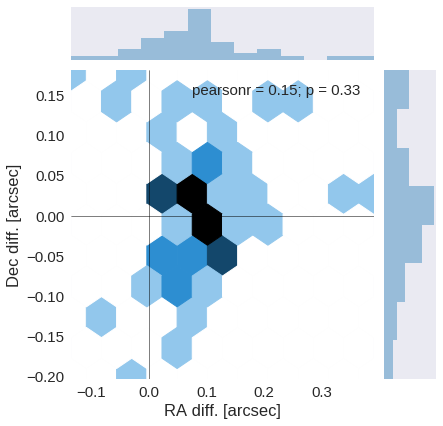

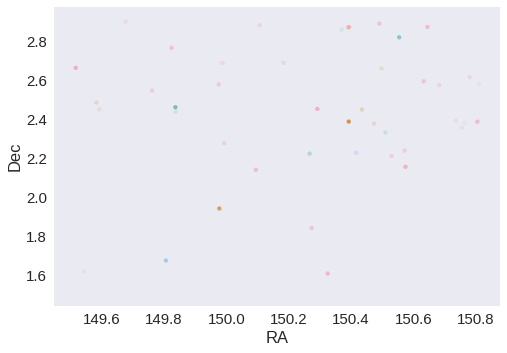

In [12]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [13]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.07898549040419311 arcsec
Dec correction: -0.010563906203397977 arcsec


In [14]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

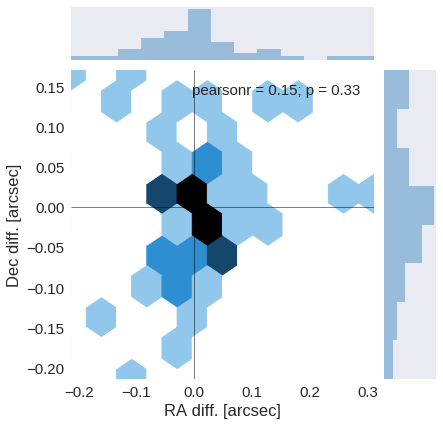

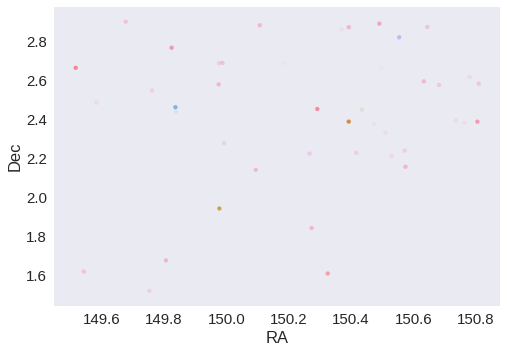

In [15]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [16]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [17]:
GAIA_FLAG_NAME = "cosmos_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

46 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [18]:
catalogue.write("{}/COSMOS2015_HELP.fits".format(OUT_DIR), overwrite=True)